## Regresion Lineal para la reconstruccion de ventas en periodos negados

In [133]:
import cx_Oracle as oc
import pandas as pd
import numpy as np

In [134]:
con=oc.connect('SYSTEM/admin@localhost')

Consulta el modelo y talla negada en la tienda

In [135]:
sql=pd.read_sql_query('''
select TI_CVE_N,
       ULT_SUST_DEF_N,
       TALLA_INI_MIN,
       TALLA_FIN_MAX,
       TA_CVE_N,
       FECHA,
       EXISTENCIA,
       VENTA
from ventas
where ult_sust_def_n=1560 and 
ta_cve_n=26
''',con)

In [136]:
df=pd.DataFrame(sql)

Establece la fecha como indice

In [137]:
df = df.set_index('FECHA')
df.head(10)

,TI_CVE_N,ULT_SUST_DEF_N,TALLA_INI_MIN,TALLA_FIN_MAX,TA_CVE_N,EXISTENCIA,VENTA
FECHA,,,,,,,
2019-03-01,1,1560,25.0,32.0,26.0,19,0
2019-03-02,1,1560,25.0,32.0,26.0,19,0
2019-03-03,1,1560,25.0,32.0,26.0,19,1
2019-03-04,1,1560,25.0,32.0,26.0,18,1
2019-03-05,1,1560,25.0,32.0,26.0,17,3
2019-03-06,1,1560,25.0,32.0,26.0,14,2
2019-03-07,1,1560,25.0,32.0,26.0,12,1
2019-03-08,1,1560,25.0,32.0,26.0,11,1
2019-03-09,1,1560,25.0,32.0,26.0,10,1


Se muestra el comportamiento de la venta vs existencia

In [138]:
import seaborn as sns

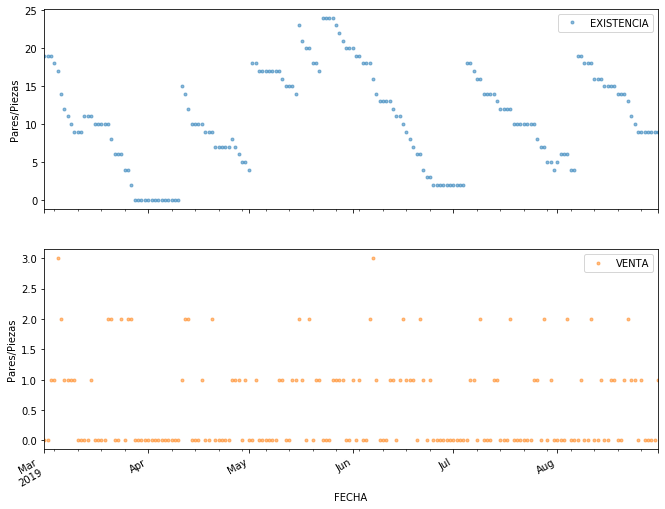

In [139]:
cols_plot = ['EXISTENCIA', 'VENTA']
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Pares/Piezas')

Se obtiene el dia de la semana para hacer la regresion lineal con ventas del mismo dia

In [140]:
# Add columns with year, month, and weekday name
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday Name'] = df.index.weekday_name
df['Day Number'] = df.index.dayofyear

negados=df[df["EXISTENCIA"]==0]
negados.head(14)

,TI_CVE_N,ULT_SUST_DEF_N,TALLA_INI_MIN,TALLA_FIN_MAX,TA_CVE_N,EXISTENCIA,VENTA,Year,Month,Weekday Name,Day Number
FECHA,,,,,,,,,,,
2019-03-28,1,1560,25.0,32.0,26.0,0,0,2019,3,Thursday,87
2019-03-29,1,1560,25.0,32.0,26.0,0,0,2019,3,Friday,88
2019-03-30,1,1560,25.0,32.0,26.0,0,0,2019,3,Saturday,89
2019-03-31,1,1560,25.0,32.0,26.0,0,0,2019,3,Sunday,90
2019-04-01,1,1560,25.0,32.0,26.0,0,0,2019,4,Monday,91
2019-04-02,1,1560,25.0,32.0,26.0,0,0,2019,4,Tuesday,92
2019-04-03,1,1560,25.0,32.0,26.0,0,0,2019,4,Wednesday,93
2019-04-04,1,1560,25.0,32.0,26.0,0,0,2019,4,Thursday,94
2019-04-05,1,1560,25.0,32.0,26.0,0,0,2019,4,Friday,95


Se localiza el periodo negado

In [141]:
periodo=df.loc['2019-03-01':'2019-04-30']

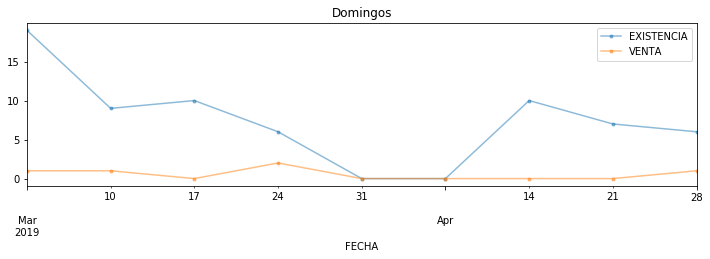

In [142]:
sunday=periodo[periodo['Weekday Name']=='Sunday']

axes = sunday[['EXISTENCIA', 'VENTA']].plot(marker='.', alpha=0.5, linestyle='-', figsize=(12, 3), title='Domingos')

Se toman los dias con existencia para hacer la regresion lineal

In [170]:
domingos=sunday[sunday["EXISTENCIA"]>0]
X = domingos["Day Number"].to_numpy().reshape(-1, 1)
Y = domingos["VENTA"].to_numpy().reshape(-1, 1)
print(X)
print(Y)

[[ 62]
 [ 69]
 [ 76]
 [ 83]
 [104]
 [111]
 [118]]
[[1]
 [1]
 [0]
 [2]
 [0]
 [0]
 [1]]


Se calcula la Regresion Lineal

In [171]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X, Y)
print(lm.intercept_,lm.coef_,lm.score(X, Y))

[1.64008322] [[-0.01040222]] 0.09101941747572817


Se estiman las ventas de todos los dias incluidos los dias negados

In [175]:
x = sunday["Day Number"].to_numpy().reshape(-1, 1)
y = lm.predict(x)
sunday["vta_estimada"]=y

C:\Users\jcjim\Anaconda3\envs\IA\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Se grafican las ventas estimadas con la regresion lineal

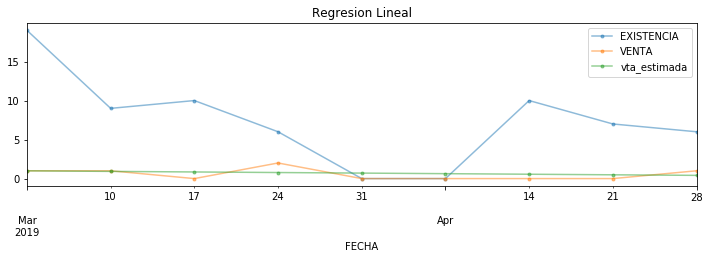

In [176]:
sunday[['EXISTENCIA', 'VENTA','vta_estimada']].plot(marker='.', alpha=0.5, linestyle='-', figsize=(12, 3), title='Regresion Lineal')

In [177]:
sunday[sunday["EXISTENCIA"]==0]

,TI_CVE_N,ULT_SUST_DEF_N,TALLA_INI_MIN,TALLA_FIN_MAX,TA_CVE_N,EXISTENCIA,VENTA,Year,Month,Weekday Name,Day Number,vta_estimada
FECHA,,,,,,,,,,,,
2019-03-31,1,1560,25.0,32.0,26.0,0,0,2019,3,Sunday,90,0.703883
2019-04-07,1,1560,25.0,32.0,26.0,0,0,2019,4,Sunday,97,0.631068
